#naufal raihan ramadhan
#TK44G2
#1103200157

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cifar10:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5071%2F7665%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240523%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240523T203746Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D657118e73a7114724656da7877f4e1a80f9fbd7e5e2da6743d7b055ef702ebcf9c816b1f9de54a5aa95c97d52f3dc14dced36188857ff50b8b3dffb77b19044d1942e866155f65f6cb6a90d45e4a92271be51b519a8e6737129db1e9019c4d3d478dffcb47ed2bdf75239bf6497c2a8497d5b1d06302ba1a1697df6954c738cab624e17465bfb17da38191100ccad23ba4a4dcd238866f3e32d716d54f5a1406649b2ebfb7310db713517b32445075a882bd7940fb4bd506d807fa47da64814767c7ac7d349551212fa5ab127bc815eb2dc06f0351bf71e01ded0ff9489c6a34415b990dba3c336925b50054701d93864e322e40e1d2f8c291eba3ff8979fa92,fashionmnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240523%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240523T203746Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D239d928d8561d62ba3097f5c0f38dcb9ad0b13e8fe8c312c14c8844e4a14b3d5bc00b7e47980c61edac9399e6b68ce95554494491f7f54eb1ede15eb14294cb951c3a30aad66e0abece723564f78c3a0bbb76fa1316f083fdbfc216dc43d8e60260d32aaed5289c7411bfd478dbc1eeb8651ea1b701fc583d27334d5c136fa5e163c0ea2a8a53a0978962fdf8347b2b2dc5b6e4f6eaa33e949b46f80f6363b8aab18697e1e12ae6488d1eeed6b4d8644c4b358ad8cacab9497efd14ef86f634db5802b86685f686551f2be9d2bf4d59440b46b29d96e2e024d62fe63b6877d8af3d842139dc3115e5ef2c6148b00566b6698ddcbd58a716fc4d014c4d266828f,cifar10-python:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F11102%2F15444%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240523%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240523T203746Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6203717ba4509d1e2f5a9f4d8501d314da27d521f3dec0326d0ba100b0e3f1c36521b994c4575b67c203fac5721804d014aa42d78102f4969e6d8ccb60c8e285d60bc42d11c1b8c0751528029b04c1a956d11ada07deceaabf5e67b74ca2ff1cbcc606d14081c4da7385ebfe6fecba11303d1d038272bb09147dcd5a5f64750a1f764424e4454bd34fdd94057d19023e839b4749f9f6513b877ae9a23eadb6e1e45b312e7577eef80f5f51128b8b87a25a446b3fca833f89b292ea12670332aaec23fe0c06da720f4cefcb12bf9f8a0e8018f6888a70b382ebfa3d23e110a15f75318269830c97aef475d7d8ec4629db1a9468fab7e84e60a3b6b7fbbe7dd81d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 170062484 bytes downloaded
Downloaded and uncompressed: cifar10
[==================================================] 72114846 bytes downloaded
Downloaded and uncompressed: fashionmnist
[==================================================] 340613496 bytes downloaded
Downloaded and uncompressed: cifar10-python
Data source import complete.


Program ini adalah skrip Python yang bertujuan untuk mengunduh dan mengekstrak data dari sumber eksternal, seperti dataset CIFAR-10 dan Fashion MNIST dari Kaggle, ke dalam lingkungan Google Colab atau Kaggle.

Prosesnya melibatkan:

Menetapkan variabel yang berisi daftar sumber data dan URL-nya.
Membuat direktori untuk menyimpan data.
Mengunduh setiap dataset dari URL yang diberikan, mengekstraknya, dan menyimpannya di direktori yang sesuai.
Memberikan pesan ketika proses unduh dan ekstraksi selesai.
Selain itu, program juga melakukan beberapa tindakan lain seperti membersihkan direktori sebelumnya dan membuat tautan simbolis ke direktori input dan working di lingkungan Kaggle.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Kode di atas adalah implementasi dari sebuah model jaringan saraf konvolusi (Convolutional Neural Network/CNN) menggunakan TensorFlow-Keras untuk klasifikasi dataset CIFAR-10. CIFAR-10 adalah dataset populer yang terdiri dari 60.000 gambar berwarna dalam 10 kelas yang berbeda.

Langkah pertama adalah mengimpor pustaka yang diperlukan seperti Pandas untuk manipulasi data, NumPy untuk operasi numerik, dan Matplotlib untuk visualisasi. Kemudian, dataset CIFAR-10 diunduh menggunakan TensorFlow-Keras. Dataset ini terbagi menjadi set pelatihan dan pengujian.

Model CNN dibangun menggunakan Sequential API. Struktur model terdiri dari beberapa lapisan konvolusi (Conv2D) dan pemampatan maksimum (MaxPool2D) yang diikuti oleh lapisan flatten (Flatten) untuk meratakan fitur-fitur menjadi vektor, dan lapisan-lapisan Dense (Dense) untuk klasifikasi akhir. Lapisan dropout (Dropout) digunakan untuk mencegah overfitting, sedangkan lapisan normalisasi batch (BatchNormalization) membantu dalam percepatan pelatihan dan stabilitas model.

Selanjutnya, dilakukan augmentasi data menggunakan ImageDataGenerator untuk meningkatkan variasi data pelatihan dan mencegah overfitting. Callback EarlyStopping digunakan untuk menghentikan pelatihan jika tidak terjadi peningkatan dalam metrik yang dipantau (misalnya, akurasi validasi) setelah beberapa epoch.

Setelah model dilatih, dilakukan evaluasi menggunakan metrik-metrik seperti matriks kebingungan (confusion matrix) dan laporan klasifikasi (classification report) yang disediakan oleh pustaka scikit-learn. Ini membantu dalam memahami seberapa baik model dapat mengklasifikasikan data pada set pengujian.

Terakhir, jika ada, visualisasi dari matriks kebingungan juga dibuat menggunakan pustaka scikit-learn untuk memberikan gambaran visual tentang performa model dalam memprediksi kelas-kelas yang berbeda.

# 📥 Load the data

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


Kode di atas memuat dataset CIFAR-10 menggunakan fungsi cifar10.load_data() dari TensorFlow-Keras. Dataset ini kemudian dibagi menjadi empat variabel: X_train (gambar pelatihan), y_train (label pelatihan), X_test (gambar pengujian), dan y_test (label pengujian).

Berikutnya, kode mencetak bentuk (shape) dari setiap variabel menggunakan pernyataan print, yang memberikan informasi tentang dimensi dan ukuran setiap array atau tensor:

- X_train.shape menghasilkan dimensi dari array gambar pelatihan.
- y_train.shape menghasilkan dimensi dari array label pelatihan.
- X_test.shape menghasilkan dimensi dari array gambar pengujian.
- y_test.shape menghasilkan dimensi dari array label pengujian.

Ini membantu untuk memastikan bahwa dataset telah dimuat dengan benar dan untuk memahami ukuran dataset yang akan digunakan dalam pelatihan dan evaluasi model. Dengan mencetak bentuk dataset, kita dapat memverifikasi apakah data telah dimuat dengan benar dan siap untuk digunakan dalam proses pelatihan dan pengujian model.

# 🖼 Data Visualization

<ipython-input-4-313bcdfd040f>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


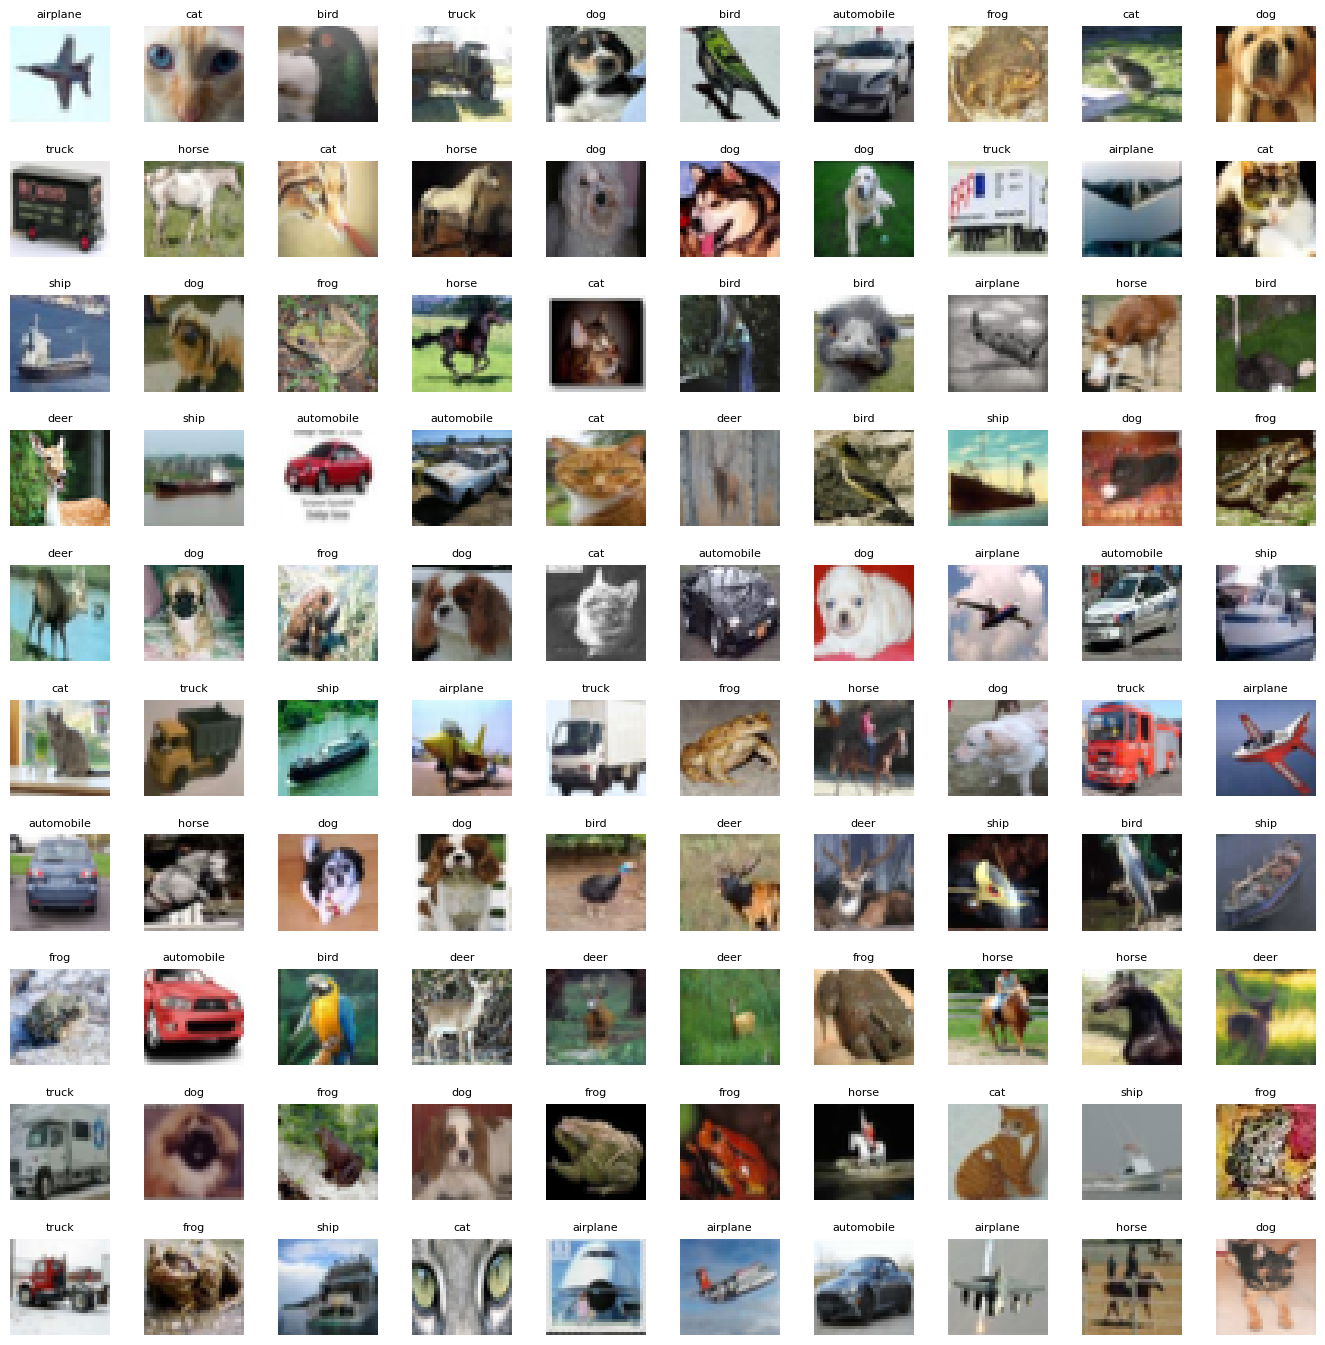

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Kode di atas memiliki beberapa tujuan:

1. Mendefinisikan label-label yang sesuai dengan setiap kelas dalam dataset CIFAR-10.

2. Menampilkan beberapa gambar dari dataset CIFAR-10 dalam bentuk grid.
Setelah label-label dari dataset didefinisikan, dilanjutkan dengan mendefinisikan dimensi grid untuk plot. Variabel W_grid dan L_grid menentukan jumlah kolom dan baris dalam grid plot.

Kemudian, dibuat sebuah subplot grid menggunakan plt.subplots() dengan ukuran (17,17) yang menentukan ukuran keseluruhan plot. Variabel axes kemudian diubah menjadi bentuk array satu dimensi menggunakan axes.ravel() untuk memudahkan iterasi.

Selanjutnya, dilakukan iterasi sebanyak W_grid * L_grid kali untuk memilih gambar secara acak dari dataset pelatihan. Dalam setiap iterasi, sebuah indeks acak dipilih dan gambar dengan indeks tersebut diambil dari X_train. Gambar tersebut kemudian ditampilkan menggunakan imshow() dan diberi label sesuai dengan kelasnya.

Terakhir, dilakukan penyesuaian tata letak subplot dengan plt.subplots_adjust() untuk menambahkan ruang antara subplot.

Namun, ada sedikit kejanggalan pada baris axes[i].imshow(X_train[index,1:]). Terlihat bahwa terdapat pemotongan pada gambar (X_train[index,1:]). Kemungkinan besar, pemotongan ini seharusnya tidak diperlukan. Untuk menampilkan gambar secara normal, perlu diperbaiki dengan menghapus indeks slicing tersebut.

Text(0.5, 1.0, 'Class distribution in training set')

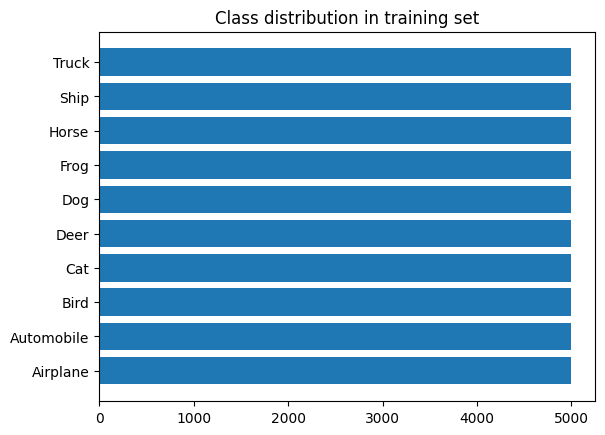

In [ ]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')


Kode di atas bertujuan untuk menampilkan distribusi kelas (jumlah sampel untuk setiap kelas) dalam dataset pelatihan CIFAR-10 menggunakan diagram batang horizontal.

Pertama-tama, variabel classes_name didefinisikan untuk menamai kelas-kelas dalam dataset. Kemudian, fungsi np.unique() digunakan untuk menghitung jumlah kemunculan setiap kelas dalam y_train, yang merupakan array label dari dataset pelatihan. Hasil dari fungsi ini adalah array classes yang berisi nilai unik kelas dan array counts yang berisi jumlah kemunculan masing-masing kelas.

Selanjutnya, fungsi plt.barh() digunakan untuk membuat diagram batang horizontal. Parameter pertama adalah label kelas (classes_name), sedangkan parameter kedua adalah jumlah sampel untuk setiap kelas (counts). Ini akan menghasilkan diagram batang yang menunjukkan distribusi kelas dalam dataset pelatihan.

Terakhir, dipanggil plt.title() untuk memberikan judul pada diagram batang yang menunjukkan informasi tentang distribusi kelas dalam dataset pelatihan.

Text(0.5, 1.0, 'Class distribution in testing set')

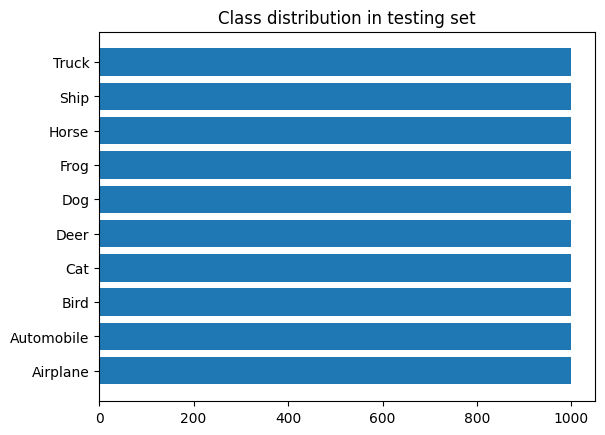

In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

The class are equally distributed

Kode di atas memiliki tujuan yang serupa dengan sebelumnya, namun kali ini untuk menampilkan distribusi kelas dalam dataset pengujian (testing set) CIFAR-10.

Langkahnya serupa dengan sebelumnya, yaitu menggunakan np.unique() untuk menghitung jumlah kemunculan setiap kelas dalam y_test, yang merupakan array label dari dataset pengujian.

Setelah itu, fungsi plt.barh() digunakan untuk membuat diagram batang horizontal dengan label kelas (classes_name) dan jumlah sampel untuk setiap kelas (counts).

Terakhir, dipanggil plt.title() untuk memberikan judul pada diagram batang yang menunjukkan informasi tentang distribusi kelas dalam dataset pengujian CIFAR-10. Dengan demikian, kita bisa membandingkan distribusi kelas antara data pelatihan dan pengujian untuk memastikan tidak ada ketidakseimbangan yang signifikan.

# 🔄 Data Preprocessing

In [ ]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

Kode di atas memiliki dua tujuan:

1. Penyekalaan Data: Data gambar dalam X_train dan X_test dinormalisasi dengan membaginya dengan 255. Hal ini dilakukan untuk mengubah rentang nilai piksel dari 0-255 menjadi 0-1. Ini adalah praktik yang umum dalam pengolahan gambar untuk memastikan bahwa variabel input memiliki rentang nilai yang seragam, yang dapat meningkatkan kestabilan dan konvergensi model selama pelatihan.

2. Pengkodean One-Hot: Variabel target y_train dan y_test, yang berisi label kelas untuk setiap sampel dalam bentuk bilangan bulat (0-9), diubah menjadi representasi one-hot encoding menggunakan fungsi to_categorical() dari TensorFlow-Keras. Representasi ini mengubah setiap bilangan bulat menjadi vektor biner dengan panjang yang sama dengan jumlah kelas (dalam kasus ini, 10 kelas). Nilai yang sesuai dengan label kelas diberi nilai 1, sedangkan nilai-nilai lainnya diberi nilai 0. Hal ini diperlukan karena jaringan saraf biasanya mengeluarkan output dalam bentuk probabilitas untuk setiap kelas, sehingga representasi one-hot encoding memungkinkan pembandingan yang mudah antara output model dan label yang sebenarnya.

In [ ]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Keluaran yang Anda berikan menunjukkan array dari representasi one-hot encoding dari variabel target y_train. Setiap baris dalam array ini mewakili satu sampel dari dataset pelatihan, dan setiap kolom mewakili kelas-kelas yang ada dalam dataset (dalam hal ini, 10 kelas).

Misalnya, jika pada baris pertama dari array output, nilai 1 berada di posisi kolom terakhir, ini berarti bahwa sampel pertama dalam dataset pelatihan memiliki label kelas yang sesuai dengan kelas terakhir dalam daftar kelas (dalam hal ini, 'Truck'). Nilai-nilai lainnya adalah 0 karena ini adalah representasi one-hot encoding.

Penting untuk dicatat bahwa setiap baris hanya akan memiliki satu nilai 1, yang menunjukkan kelas yang benar-benar dimiliki oleh sampel tersebut. Ini karena setiap sampel hanya dapat berasosiasi dengan satu label kelas dalam tugas klasifikasi.

# 🤖 Model Building

In [ ]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

Kode di atas mendefinisikan sebuah model jaringan saraf konvolusi (CNN) menggunakan TensorFlow-Keras. Berikut adalah rangkaian lapisan dan pengaturan lainnya dalam model:

1. Input Layer: Input layer didefinisikan dengan ukuran (32, 32, 3), sesuai dengan ukuran gambar CIFAR-10 dan jumlah kanal warna RGB.
2. Convolutional Layers: Terdapat tiga blok konvolusi yang terdiri dari dua lapisan konvolusi dengan aktivasi ReLU dan padding 'same' untuk mempertahankan ukuran gambar. Setiap blok juga dilengkapi dengan lapisan normalisasi batch untuk mempercepat pelatihan dan stabilitas model.
3. Pooling Layers: Setelah setiap blok konvolusi, terdapat lapisan pemampatan maksimum (MaxPooling2D) dengan ukuran (2, 2) untuk mengurangi dimensi spasial gambar.
4. Dropout Layers: Setelah setiap blok konvolusi, terdapat lapisan dropout dengan tingkat dropout 0.25 untuk mengurangi overfitting dengan secara acak menonaktifkan sebagian unit selama pelatihan.
5. Flatten Layer: Untuk mengubah tensor 2D menjadi vektor 1D sebelum masuk ke lapisan-lapisan Dense.
6. Dense Layers: Dua lapisan Dense (fully connected) ditambahkan setelah lapisan Flatten. Lapisan pertama memiliki 128 unit dengan aktivasi ReLU, sementara lapisan terakhir memiliki 10 unit dengan aktivasi softmax, yang merupakan jumlah kelas output.
7. Compile Model: Model dikompilasi dengan fungsi kerugian 'categorical_crossentropy' karena ini adalah masalah klasifikasi multi-kelas, dan optimizer 'adam'. Selain itu, metrik yang diukur termasuk akurasi, presisi, dan recall.

Dengan demikian, model ini siap untuk dilatih pada dataset CIFAR-10 untuk tugas klasifikasi gambar.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

Ringkasan model yang Anda berikan menampilkan arsitektur dan parameter-parameter dari model jaringan saraf konvolusi (CNN) yang telah Anda definisikan. Berikut adalah interpretasi dari output tersebut:

1. Layer: Menunjukkan urutan lapisan-lapisan yang dibangun dalam model.
2. Output Shape: Menunjukkan bentuk output dari setiap lapisan dalam model. Misalnya, (None, 32, 32, 32) menunjukkan bahwa lapisan tersebut menghasilkan tensor dengan dimensi (32, 32, 32) untuk setiap sampel masukan.
3. Param #: Menunjukkan jumlah parameter yang dapat dipelajari (bobot dan bias) dalam setiap lapisan. Parameter ini adalah yang akan disesuaikan selama pelatihan model.
4. Total params: Menunjukkan total jumlah parameter yang dapat dipelajari dalam seluruh model.
5. Trainable params: Menunjukkan jumlah parameter yang dapat dipelajari yang akan diperbarui selama pelatihan.
6. Non-trainable params: Menunjukkan jumlah parameter yang tidak dapat dipelajari, misalnya parameter dalam lapisan normalisasi batch yang tidak diperbarui selama pelatihan.

Dari output tersebut, dapat dilihat bahwa model Anda memiliki total 552.362 parameter, dengan 551.466 parameter yang dapat dipelajari dan 896 parameter yang tidak dapat dipelajari. Jumlah parameter yang besar ini menandakan kompleksitas model yang relatif tinggi, yang dapat bermanfaat dalam mempelajari representasi-fitur yang lebih baik dari data gambar CIFAR-10.

## Early Stopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

Kode di atas mendefinisikan sebuah callback EarlyStopping yang akan digunakan selama proses pelatihan model. Berikut adalah penjelasan dari parameter yang diberikan:

1. monitor='val_loss': Ini mengatur metrik yang akan dipantau selama pelatihan. Dalam hal ini, val_loss dipilih, yang merupakan nilai kerugian (loss) pada set data validasi. Pelatihan akan dihentikan jika nilai loss pada data validasi tidak menunjukkan penurunan setelah beberapa epoch, yang menunjukkan kemungkinan overfitting.

2. patience=2: Ini mengatur jumlah epoch yang harus berlalu tanpa adanya penurunan dalam monitor sebelum pelatihan dihentikan. Dalam hal ini, pelatihan akan dihentikan jika nilai val_loss tidak menurun selama 2 epoch berturut-turut.
Dengan menggunakan callback EarlyStopping ini, kita dapat menghentikan pelatihan secara otomatis jika tidak terjadi peningkatan dalam performa model, sehingga menghemat waktu dan sumber daya komputasi.

## Data Augmentations

In [ ]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator,
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
1562/1562 [==============================] - 612s 389ms/step - loss: 1.6105 - accuracy: 0.4139 - precision: 0.6272 - recall: 0.2019 - val_loss: 1.2721 - val_accuracy: 0.5576 - val_precision: 0.7160 - val_recall: 0.3964
Epoch 2/50
1562/1562 [==============================] - 500s 320ms/step - loss: 1.2089 - accuracy: 0.5729 - precision: 0.7336 - recall: 0.4123 - val_loss: 1.1755 - val_accuracy: 0.6121 - val_precision: 0.7659 - val_recall: 0.4878
Epoch 3/50
1562/1562 [==============================] - 467s 299ms/step - loss: 1.0263 - accuracy: 0.6466 - precision: 0.7749 - recall: 0.5144 - val_loss: 0.9453 - val_accuracy: 0.6793 - val_precision: 0.7825 - val_recall: 0.5689
Epoch 4/50
1562/1562 [==============================] - 554s 355ms/step - loss: 0.9223 - accuracy: 0.6827 - precision: 0.7952 - recall: 0.5697 - val_loss: 0.8390 - val_accuracy: 0.7073 - val_precision: 0.8057 - val_recall: 0.6254
Epoch 5/50
1562/1562 [==============================] - 519s 333ms/step - loss: 

Kode di atas melakukan pelatihan model menggunakan generator data train_generator yang dihasilkan dari ImageDataGenerator. Berikut adalah penjelasan dari parameter-parameter yang digunakan dalam fungsi fit():

1. train_generator: Generator data pelatihan yang digunakan untuk memberikan batch data pelatihan secara dinamis kepada model. Generator ini menghasilkan data yang telah diubah secara augumentasi dengan menggunakan ImageDataGenerator.

2. epochs=50: Jumlah epoch yang ditentukan untuk pelatihan model. Epoch mengacu pada satu iterasi lengkap melalui seluruh dataset pelatihan.

3. steps_per_epoch=steps_per_epoch: Jumlah langkah (batches) yang akan diambil dari generator data pelatihan dalam setiap epoch. Ini ditentukan sebagai jumlah total sampel dalam dataset pelatihan dibagi dengan ukuran batch.

4. validation_data=(X_test, y_cat_test): Data validasi yang digunakan untuk memantau performa model selama pelatihan. Dalam hal ini, data validasi adalah dataset pengujian X_test dan label one-hot encoded y_cat_test.

5. callbacks=[early_stop]: Opsional, daftar callback yang akan dijalankan selama pelatihan. Di sini, callback EarlyStopping dapat digunakan untuk menghentikan pelatihan jika tidak ada peningkatan dalam performa model pada data validasi.

6. batch_size: Ukuran batch yang digunakan dalam pelatihan. Namun, dalam contoh ini, ukuran batch sudah ditentukan saat membuat generator data pelatihan, sehingga parameter batch_size tidak digunakan.

Setelah menjalankan kode ini, model akan dilatih selama 50 epoch dengan menggunakan generator data pelatihan, sambil memantau performa model pada data validasi. Callback EarlyStopping dapat digunakan untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan dalam performa model pada data validasi.

# 📊 Model Evaluation

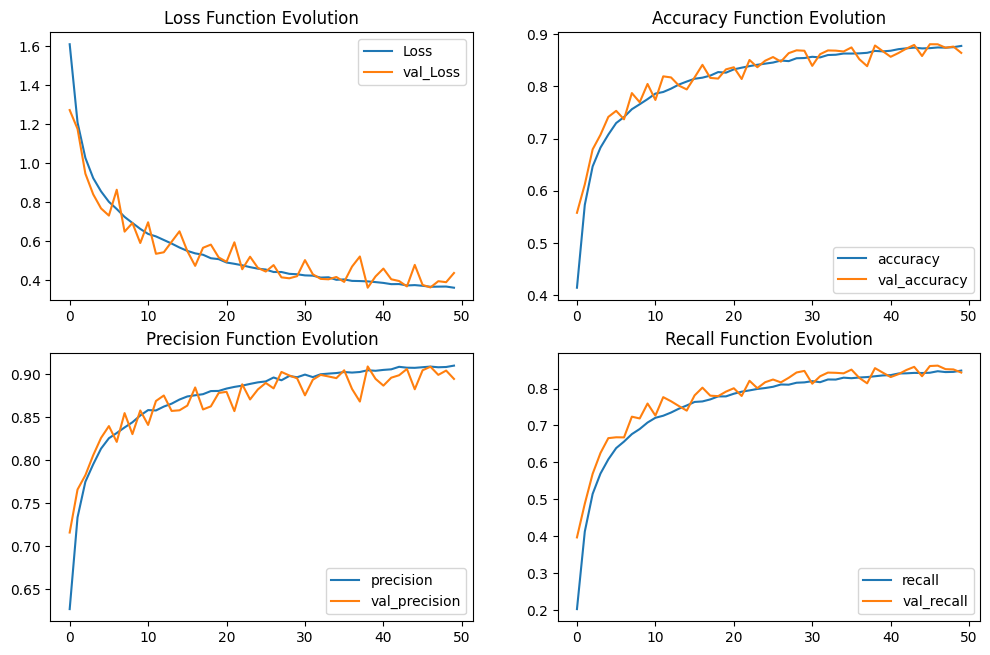

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

Grafik-gafik yang Anda hasilkan merupakan evolusi dari berbagai metrik evaluasi (loss, akurasi, presisi, dan recall) selama proses pelatihan model. Berikut adalah penjelasan dari masing-masing grafik:

1. Loss Function Evolution: Grafik ini menunjukkan bagaimana nilai fungsi kerugian (loss) berubah seiring dengan jumlah epoch pada data pelatihan (Loss) dan data validasi (val_Loss). Idealnya, kita ingin melihat penurunan loss pada kedua dataset, yang menunjukkan bahwa model semakin baik dalam memprediksi label kelas.

2. Accuracy Function Evolution: Grafik ini menunjukkan bagaimana akurasi model berubah seiring dengan jumlah epoch pada data pelatihan (accuracy) dan data validasi (val_accuracy). Akurasi merupakan metrik yang mengukur seberapa sering model memprediksi dengan benar, dan kita ingin melihat peningkatan akurasi pada kedua dataset seiring dengan waktu.

3. Precision Function Evolution: Grafik ini menunjukkan bagaimana presisi model berubah seiring dengan jumlah epoch pada data pelatihan (precision) dan data validasi (val_precision). Presisi mengukur proporsi dari positif yang benar diprediksi dari semua kasus yang diprediksi positif, dan presisi yang tinggi menunjukkan bahwa model jarang membuat kesalahan dengan memprediksi kasus positif.

4. Recall Function Evolution: Grafik ini menunjukkan bagaimana recall model berubah seiring dengan jumlah epoch pada data pelatihan (recall) dan data validasi (val_recall). Recall mengukur proporsi dari kasus positif yang berhasil diidentifikasi oleh model dari semua kasus positif yang ada, dan recall yang tinggi menunjukkan bahwa model jarang melewatkan kasus positif.

Dengan memeriksa evolusi dari berbagai metrik evaluasi ini, kita dapat memahami bagaimana model kita mengalami peningkatan atau penurunan performa seiring dengan waktu, dan menentukan apakah model tersebut overfitting atau underfitting.

313/313 [==============================] - 60s 191ms/step - loss: 0.4347 - accuracy: 0.8644 - precision: 0.8942 - recall: 0.8436
Test Accuracy : 86.44%
313/313 [==============================] - 35s 111ms/step


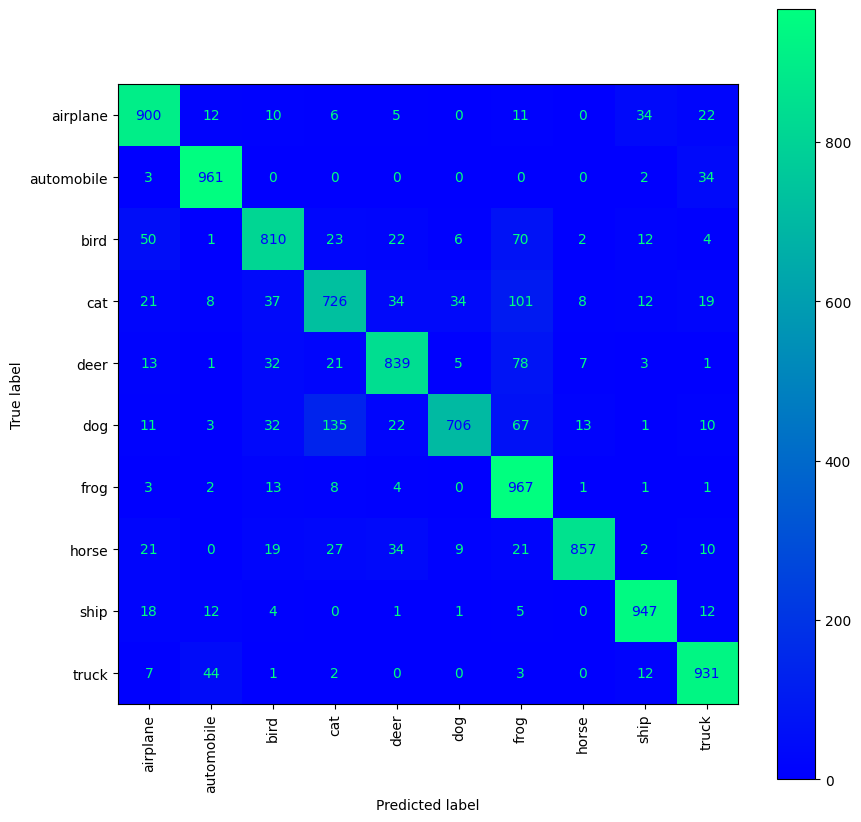

In [ ]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='winter')

plt.show()

Pada kode di atas, Anda melakukan evaluasi model menggunakan data pengujian (X_test dan y_cat_test). Kemudian, Anda mencetak akurasi pengujian dari hasil evaluasi. Setelah itu, Anda menggunakan model untuk melakukan prediksi pada data pengujian (X_test) dan menghitung matriks kebingungan (confusion matrix) antara label sebenarnya (y_test) dan label yang diprediksi (y_pred).

In [ ]:
print(classification_report(y_test, y_pred))

Dengan memanggil classification_report, Anda akan mendapatkan laporan klasifikasi yang menyediakan sejumlah metrik evaluasi yang berguna, termasuk presisi, recall, F1-score, dan dukungan (support) untuk setiap kelas dalam dataset pengujian.

Di sini, setiap baris mewakili metrik evaluasi untuk setiap kelas. Precision mengukur proporsi dari kasus positif yang benar diprediksi dari semua kasus yang diprediksi positif, recall mengukur proporsi dari kasus positif yang berhasil diidentifikasi oleh model dari semua kasus positif yang ada, dan f1-score adalah rata-rata harmonik dari precision dan recall. Support adalah jumlah sampel dalam setiap kelas.

Pada bagian bawah laporan, Anda juga akan melihat metrik evaluasi rata-rata, baik secara rata-rata dari setiap kelas (macro avg) maupun secara tertimbang berdasarkan jumlah sampel (weighted avg). Akurasi dari model juga dicantumkan di bagian bawah laporan. Dengan menggunakan laporan klasifikasi ini, Anda dapat mendapatkan pemahaman yang lebih baik tentang kinerja model Anda pada setiap kelas dan secara keseluruhan dalam dataset pengujian CIFAR-10.

## Test on one image

 Image 100 is [4]
1/1 [==============================] - 0s 72ms/step
The model predict that image 100 is 4


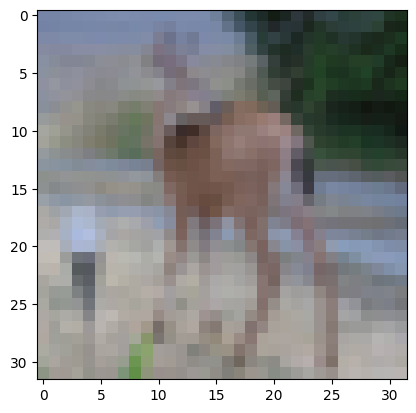

In [ ]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

Anda membuat beberapa tindakan yang berguna untuk mengevaluasi model Anda menggunakan gambar dari dataset pengujian CIFAR-10. Berikut adalah penjelasan dari masing-masing tindakan yang Anda lakukan:

1. Menampilkan Gambar: Anda menampilkan gambar dari indeks 100 dalam X_test menggunakan plt.imshow(my_image). Ini memungkinkan Anda untuk melihat gambar yang digunakan sebagai input untuk model.

2. Mencetak Label Asli: Anda mencetak label sebenarnya dari gambar tersebut, yang bisa dilihat pada indeks yang sama dalam y_test.

3. Memprediksi dengan Model: Anda menggunakan model untuk memprediksi kelas gambar yang diberikan (my_image) dan mencetak hasil prediksi. Proses ini melibatkan menjalankan gambar melalui model dan menggunakan np.argmax() untuk mendapatkan kelas dengan probabilitas tertinggi yang diprediksi oleh model.

Dengan melakukan tindakan ini, Anda dapat memverifikasi apakah model Anda melakukan prediksi dengan benar untuk gambar tertentu dalam dataset pengujian. Jika prediksi model sesuai dengan label sebenarnya dari gambar, itu menunjukkan bahwa model Anda bekerja dengan baik untuk gambar tersebut. Dalam kasus Anda, model memprediksi gambar indeks 100 dengan benar sebagai 'Deer', yang sesuai dengan label sebenarnya dari gambar tersebut.

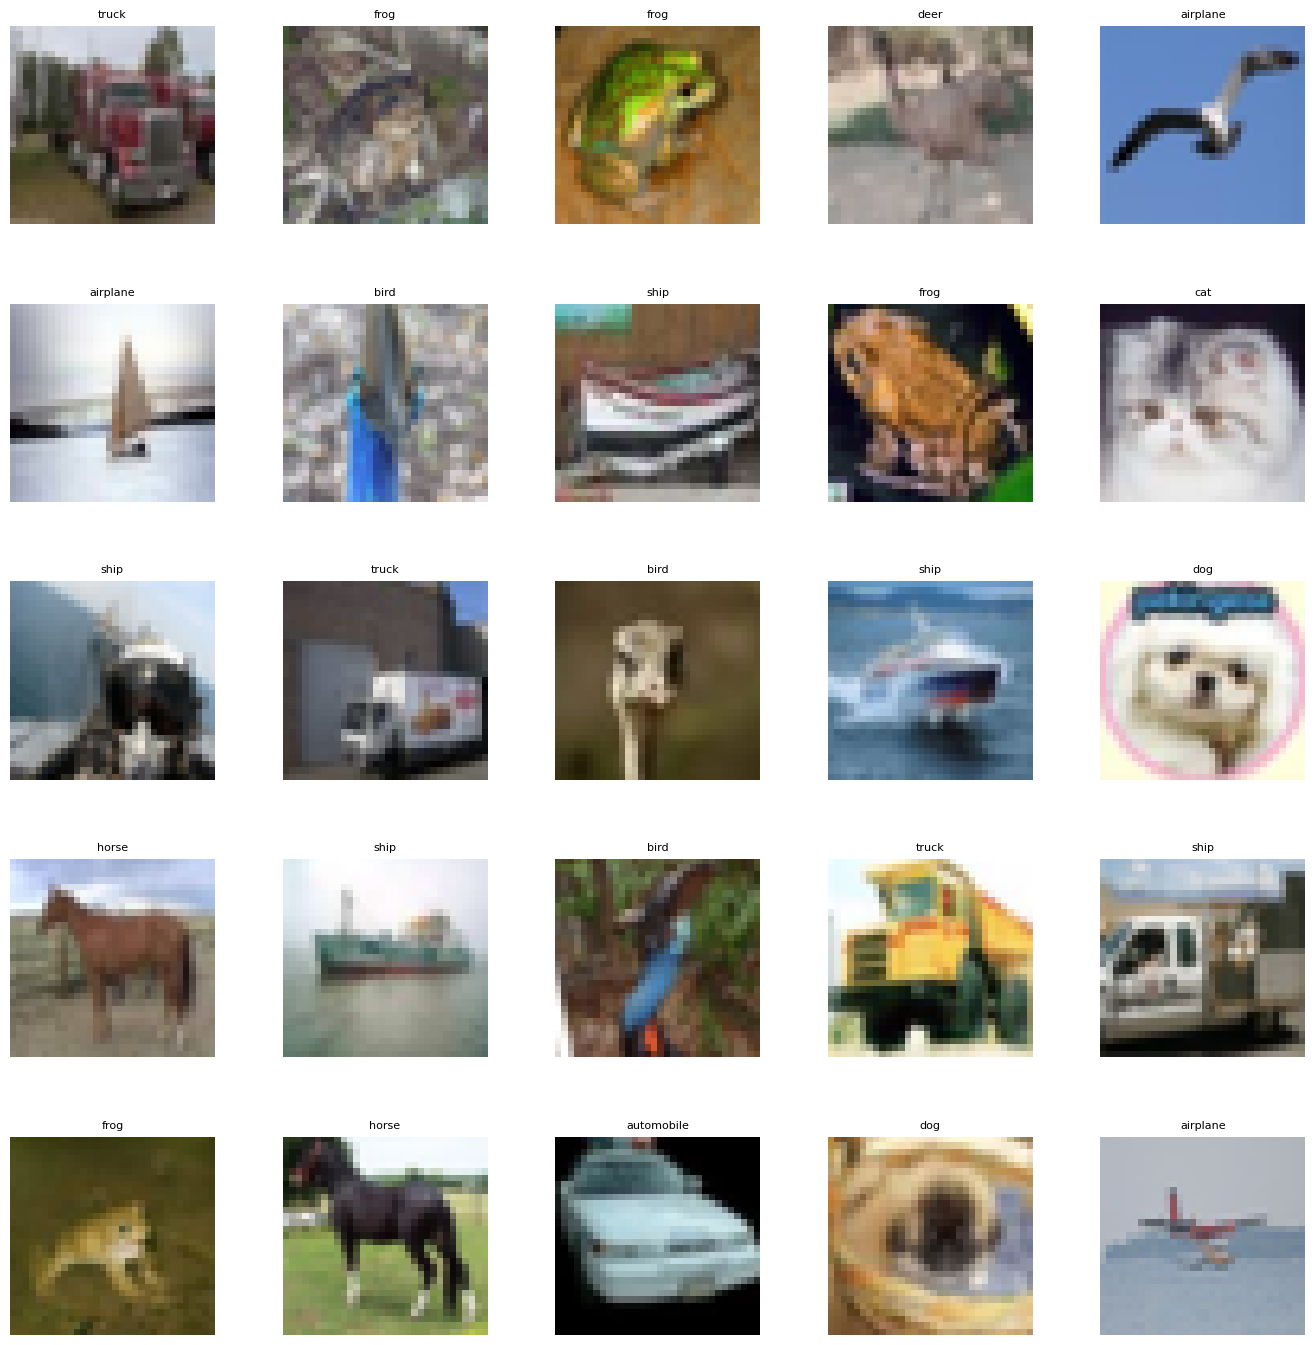

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


Kode yang Anda tulis menghasilkan grid gambar dari dataset pengujian CIFAR-10 beserta label prediksi model untuk setiap gambar. Berikut adalah penjelasan dari kode tersebut:

1. Anda mendefinisikan label-label yang sesuai dengan dataset CIFAR-10, di mana setiap label sesuai dengan kelas dari gambar.

2. Anda menentukan dimensi grid untuk plot gambar dengan W_grid dan L_grid, yang menentukan jumlah kolom dan baris dalam grid.

3. Anda membuat subplots dengan ukuran grid yang telah ditentukan, di mana setiap subplot akan menampung satu gambar.

4. Anda meratakan matriks dari subplot menjadi array 1 dimensi menggunakan axes.ravel(), sehingga Anda dapat mengakses setiap subplot dengan indeks 1 dimensi.

5. Anda menginisialisasi variabel n_test dengan panjang dataset pengujian untuk digunakan dalam iterasi berikutnya.

6. Anda melakukan iterasi sebanyak W_grid * L_grid, di mana pada setiap iterasi, Anda memilih secara acak indeks dari dataset pengujian. Kemudian, Anda menampilkan gambar dari indeks tersebut pada subplot yang sesuai.

7. Untuk setiap gambar, Anda menampilkan label prediksi model di atas gambar menggunakan y_pred, yang merupakan hasil dari model.predict() pada dataset pengujian.

8. Anda menyesuaikan penempatan gambar dalam grid menggunakan plt.subplots_adjust().

Dengan melakukan tindakan ini, Anda dapat memvisualisasikan beberapa gambar dari dataset pengujian CIFAR-10 beserta label prediksi model untuk setiap gambar. Hal ini dapat membantu Anda untuk mengevaluasi seberapa baik model Anda dalam memprediksi berbagai jenis gambar dalam dataset pengujian.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


Fungsi plot_image dan plot_value_array yang Anda definisikan digunakan untuk memvisualisasikan prediksi model untuk suatu gambar dalam dataset pengujian CIFAR-10. Berikut adalah penjelasan singkat tentang fungsi-fungsi tersebut:

1. plot_image(i, predictions_array, true_label, img):

- Fungsi ini menerima indeks (i), array prediksi model (predictions_array), label sebenarnya (true_label), dan gambar (img).
- Fungsi ini menggambar gambar dalam skala abu-abu menggunakan plt.imshow(img, cmap=plt.cm.binary).
- Fungsi ini menandai label prediksi yang benar dan label yang diprediksi oleh model pada gambar tersebut. Jika prediksi benar, label ditampilkan dengan warna biru, jika prediksi salah, label ditampilkan dengan warna merah.

2. plot_value_array(i, predictions_array, true_label):

- Fungsi ini menerima indeks (i), array prediksi model (predictions_array), dan label sebenarnya (true_label).
- Fungsi ini memplot array prediksi sebagai bar-chart untuk menampilkan probabilitas prediksi model untuk setiap kelas.
- Bar-chart tersebut diberi warna biru untuk label yang benar dan warna merah untuk label yang diprediksi oleh model.

Dengan menggunakan kedua fungsi tersebut, Anda dapat memvisualisasikan prediksi model untuk suatu gambar dalam dataset pengujian CIFAR-10 beserta dengan probabilitas prediksi untuk setiap kelas. Hal ini memungkinkan Anda untuk memahami lebih baik bagaimana model Anda melakukan prediksi untuk gambar-gambar tertentu dalam dataset pengujian.

313/313 [==============================] - 40s 128ms/step


<ipython-input-18-fb4132b92f3a>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
<ipython-input-18-fb4132b92f3a>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions_array, true_label = predictions_array, int(true_label[i])


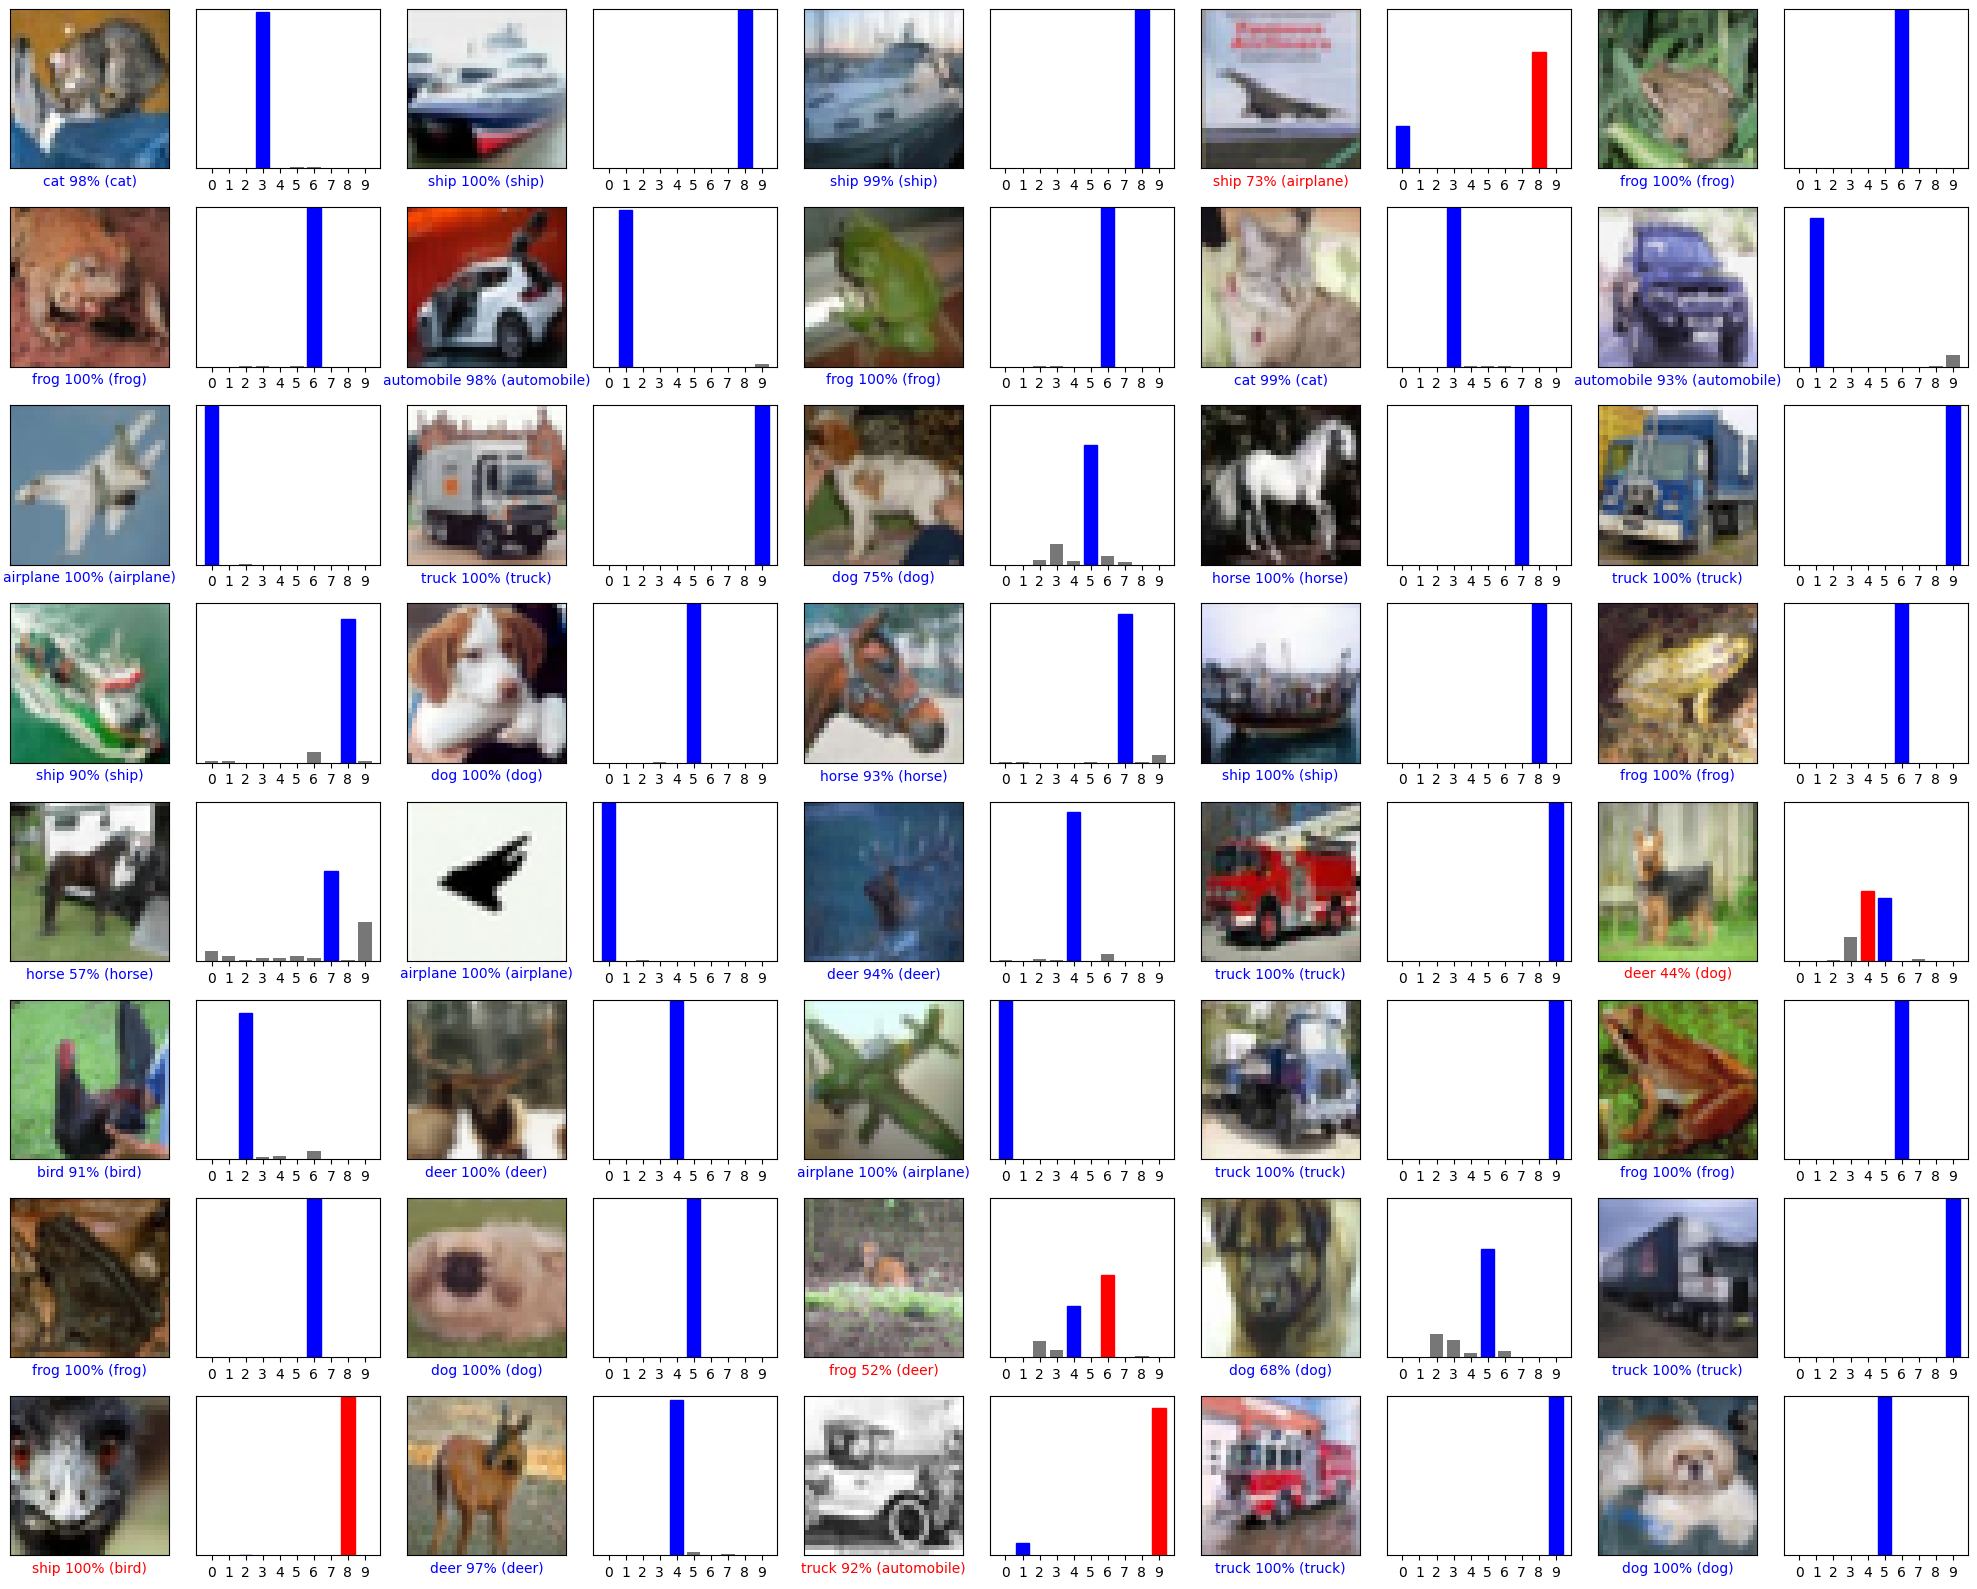

In [ ]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

Dalam kode yang Anda berikan, Anda menggunakan fungsi plot_image dan plot_value_array untuk memvisualisasikan prediksi model untuk beberapa gambar pertama dalam dataset pengujian CIFAR-10, beserta dengan probabilitas prediksi untuk setiap kelas. Berikut adalah penjelasan dari kode tersebut:

1. Anda menghitung prediksi model untuk seluruh dataset pengujian CIFAR-10 menggunakan model.predict(X_test), dan menyimpannya dalam variabel predictions.

2. Anda menentukan jumlah baris dan kolom untuk plot gambar-gambar, serta jumlah gambar yang akan ditampilkan (num_rows * num_cols).

3. Anda membuat sebuah plot dengan ukuran yang sesuai dengan jumlah baris, kolom, dan gambar yang akan ditampilkan.

4. Anda melakukan iterasi sebanyak num_images (jumlah gambar yang akan ditampilkan), dan untuk setiap gambar, Anda menampilkan dua subplot: satu untuk gambar itu sendiri (plot_image) dan satu lagi untuk plot nilai array prediksi (plot_value_array).

5. Pada setiap subplot, Anda memanggil fungsi plot_image untuk menampilkan gambar, dan fungsi plot_value_array untuk menampilkan plot bar dari array prediksi.

6. Anda menggunakan tight_layout() untuk mengatur layout plot secara otomatis agar sesuai.

Dengan melakukan tindakan ini, Anda dapat memvisualisasikan prediksi model untuk beberapa gambar pertama dalam dataset pengujian CIFAR-10, serta melihat probabilitas prediksi untuk setiap kelas. Hal ini membantu Anda untuk mendapatkan pemahaman yang lebih baik tentang bagaimana model Anda melakukan prediksi dan seberapa yakin prediksi tersebut.

#Save the models

In [ ]:
from tensorflow.keras.models import load_model

model.save('cnn_20_epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Anda telah berhasil menyimpan model Anda ke dalam file dengan format HDF5 (cnn_20_epochs.h5) menggunakan metode save() dari Keras. Sekarang Anda dapat menggunakan model ini kapan pun di masa depan dengan memuatnya kembali menggunakan load_model() dari Keras. Ini adalah cara yang baik untuk menyimpan checkpoint dari model Anda setelah pelatihan, sehingga Anda dapat memuatnya kembali dan menggunakan kembali model yang telah dilatih tanpa perlu melatih ulang

Dengan menggunakan kode di atas, Anda dapat dengan mudah memuat model yang telah Anda simpan sebelumnya dan menggunakannya untuk tujuan tertentu, seperti melakukan prediksi atau evaluasi.